<a href="https://colab.research.google.com/github/KhansKodes/Detection-of-Persuasion-Techniques-in-Memes/blob/main/detection_persuasion_techniques_memes_electra_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install  "datasets" "transformers" "pytorch-lightning"

In [ ]:
pip install torch


In [ ]:
import torch
from torch.utils.data import (
    Dataset, TensorDataset,
    DataLoader, RandomSampler,
    SequentialSampler)
import torch.nn as nn
import torchmetrics
import torchmetrics.functional as func

from pytorch_lightning import (
    LightningDataModule, LightningModule,
    Trainer, seed_everything)
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
from transformers import (
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
)

In [ ]:
import csv
import gc
import re
import numpy as np
import pandas as pd


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, num_classes=14, title='confusion matrix',
                          classes=['negative', 'positive'], cmap=plt.cm.YlGn):

    title = title

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(num_classes-0.5, -0.5)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def plot_confusion_multi(all_cm, classes):
  assert len(all_cm)==len(classes)
  label =0
  for cm in all_cm:
    class_name=classes[label]
    title="confusion matrix for "+str(class_name)
    plot_confusion_matrix(cm,2,title=title)
    label=label+1

In [ ]:
AVAIL_GPUS = 0
if torch.cuda.is_available():
    device = torch.device("cuda")
    AVAIL_GPUS = torch.cuda.device_count()
    print(f'There are {AVAIL_GPUS} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

# Main Folders

In order to run the whole code it is necessary to add a shortcut from the shared folder "DeepProject" to "MyDrive" folder, or change the **folder_name** variable, setting it to the right path.

In [ ]:
folder_name = "/content/drive/MyDrive/DeepProject/"
logs_dir = folder_name + "Logs/"

# Pre-trained Transformer Name

This section is used to choose which pre-trained model to load from HuggingFace library.

In [ ]:
#pretrained_transformer_name = "distilbert-base-cased"
pretrained_transformer_name = "google/electra-base-discriminator"
#pretrained_transformer_name = "microsoft/deberta-base"
#pretrained_transformer_name = "albert-base-v2"
#pretrained_transformer_name = "distilbert/distilroberta-base"

checkpoint_name= pretrained_transformer_name.replace("/","_")

# PTC: Propaganda Techniques corpus
For Subtask1 and Subtask2 **transfer learning** is applied: the language models are pre-trained on PTC articles corpus from [PTC TASKS ON
"DETECTION OF PROPAGANDA TECHNIQUES IN NEWS ARTICLES" challenge](https://propaganda.math.unipd.it/ptc/) (task TC). It is a dataset that labels about 450 news articles into 14 propaganda techniques.


## Data pre-processing

We generated a multi-class dataset associating to each sentence a label, starting from PTC labeling of the spans in each news article, obtaining 6128 train samples and 1063 test samples.

In [ ]:
train_PTC_labels_file_name = folder_name + "Dataset/PTC/train-task-flc-tc.labels"
train_articles_folder = folder_name + "Dataset/PTC/train-articles/"
train_PTC_dataset_file_name = folder_name + "Dataset/PTC_dataset.csv"

val_PTC_labels_file_name = folder_name + "Dataset/PTC/dev-task-flc-tc.labels"
val_articles_folder = folder_name + "Dataset/PTC/dev-articles/"
val_PTC_dataset_file_name = folder_name + "Dataset/PTC_validation_dataset.csv"

PTC_checkpoints= folder_name + "Model/PTC/"


Function used only once to create the csv dataset from the PTC articles corpus.

In [ ]:
def create_dataset(input_name, output_name, articles_folder):
    f_output = open(output_name, 'w')

    with open(input_name, 'r') as f:
        writer = csv.writer(f_output)
        writer.writerow(['text', 'label'])
        article_file_name = ""
        af = None
        for line in f:
            fields = line.split('\t')
            id_file = fields[0]
            label = fields[1]
            begin_offset = int(fields[2])
            end_offset = int(fields[3])
            file_name = articles_folder + "article" + id_file + ".txt"

            if(file_name != article_file_name):
                if(af != None):
                    af.close()
                article_file_name = articles_folder + "article" + id_file + ".txt"
                af = open(article_file_name, 'rb')

            af.seek(begin_offset)
            assert end_offset - begin_offset > 0
            text = af.read(
                end_offset - begin_offset).decode('utf-8', 'ignore').strip()
            text = re.sub('[^A-Za-z0-9!?()%-= \']+', '', text)

            writer.writerow([text, label])

    af.close()
    f.close()
    f_output.close()


In [ ]:
# create_dataset(train_PTC_labels_file_name,train_PTC_dataset_file_name, train_articles_folder)
# create_dataset(val_PTC_labels_file_name,val_PTC_dataset_file_name, val_articles_folder)

## PTC - Training

### Dataset

In [ ]:
class PTCDataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

In [ ]:
train_data = pd.read_csv(train_PTC_dataset_file_name)
val_data = pd.read_csv(val_PTC_dataset_file_name)

Overview of the dataset characteristics and of the distribution of the classes.

In [ ]:
train_data

,text,label
0,The next transmission could be more pronounced...,Appeal_to_Authority
1,when (the plague) comes again it starts from m...,Appeal_to_Authority
2,appeared,Doubt
3,"a very, very different",Repetition
4,He also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice
...,...,...
4125,"g that, WikiLeaks performed an","Exaggeration,Minimisation"
4126,n Assange is?JP: Julian is,"Name_Calling,Labeling"
4127,"isted.As a person, Julian i","Name_Calling,Labeling"
4128,rote: I ask the prime minister to do all withi...,Appeal_to_fear-prejudice


In [ ]:
train_data.describe()

,text,label
count,4130,4130
unique,4029,14
top,illegal aliens,Loaded_Language
freq,9,1387


In [ ]:
frequences = train_data.groupby(['label']).size()
frequences

,0
label,
Appeal_to_Authority,104
Appeal_to_fear-prejudice,239
"Bandwagon,Reductio_ad_hitlerum",54
Black-and-White_Fallacy,94
Causal_Oversimplification,134
Doubt,283
"Exaggeration,Minimisation",304
Flag-Waving,170
Loaded_Language,1387


As we can see in the plot below, the distribution of the samples among the classes is not balanced. This means that we could expect good results for certain classes and bad for others or, in the worst scenario, our models could be heavily biased towards the classes which have more samples. To mitigate this problem we focused on trying different kinds of loss functions.

<Axes: xlabel='label'>

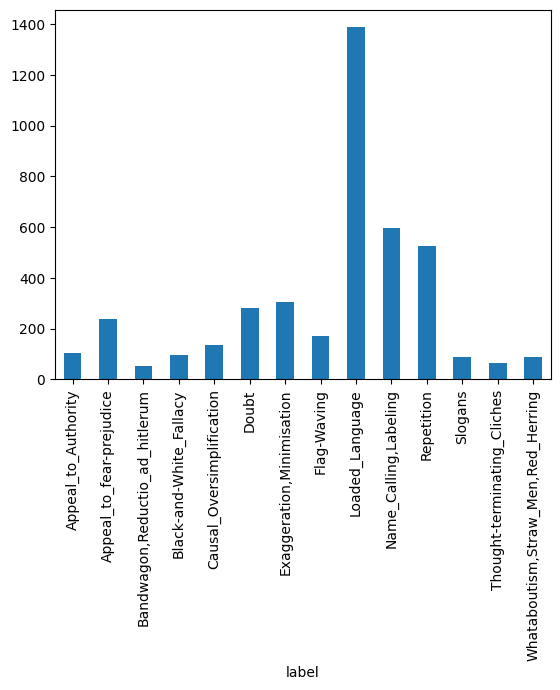

In [ ]:
frequences.plot(kind='bar')

### Define LightningDataModule

In the DataModule the sentences are encoded by a tokenizer that adds special tokens and padding, truncates to the maximum length (computed by the maxLen function) and returns the attention mask and the token ids.

We can pass the model's name as parameter to the DataModule, in this way the tokenizer's output is going to be appropriate for such model.

In [ ]:
class PTCDataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        val_data,
        model_name: str = "google/electra-base-discriminator",
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.num_labels = 14
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.le = preprocessing.LabelEncoder()

    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.le.fit(self.train_data.label.values)
        y_train = self.le.transform(self.train_data.label.values)

        self.X_val = self.val_data.text.values
        y_val = self.le.transform(self.val_data.label.values)

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = PTCDataset(self.X_train_enc,
                          self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = PTCDataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            encoded_sent = self.tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)

        return input_ids, attention_masks

    def maxLen(self):
        X_all = np.concatenate([self.X_train, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len


In [ ]:
seed_everything(42)
dm = PTCDataModule(train_data, val_data,
                   model_name=pretrained_transformer_name, batch_size=16)
dm.setup()

INFO:lightning_fabric.utilities.seed:Seed set to 42


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Loss Functions

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.CE = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        CE_loss = self.CE(inputs,targets)
        pt = torch.exp(-CE_loss)
        F_loss = (1-pt)**self.gamma * CE_loss

        return torch.mean(F_loss)

### Model

Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class PTCEvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.detach().cpu().numpy().astype(int) # Changed np.int to int
        all_labels = model.labels.detach().cpu().numpy().astype(int) # Changed np.int to int

        classes = model.le.classes_

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average='micro', zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average='macro', zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(model.num_classes)], target_names=classes))

        conf_mat = confusion_matrix(all_labels, all_predictions)
        plot_confusion_matrix(conf_mat, classes=classes)

        return

In [ ]:
class CLSExtractor(nn.Module):
    def __init__(self, name):
        super(CLSExtractor, self).__init__()
        self.isCLSLast = (True if name == 'xlnet-base-cased' else False)

    def forward(self, x):
        if(self.isCLSLast):
            return x[0][:, -1, :]
        else:
            return x[0][:, 0, :]

In [ ]:
class PTCTransformer(LightningModule):
    def __init__(
        self,
        le,
        y_train=None,
        num_classes: int = 14,
        model_name_or_path: str = "google/electra-base-discriminator",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()

        self.num_classes = num_classes

        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon

        self.save_hyperparameters()

        self.le = le

        #self.loss = nn.CrossEntropyLoss()
        self.loss = FocalLoss()
        #self.loss = WeightedCELoss(y_train)
        self.acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)

        self.labels = torch.Tensor(device=self.device)
        self.predictions = torch.Tensor(device=self.device)

        self.outputs = []  # Initialize an empty list to store outputs

        D_in, H, D_out = 768, 96, num_classes
        self.transformer = AutoModel.from_pretrained(model_name_or_path)

        self.extractor = CLSExtractor(model_name_or_path)

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        plm_output = self.transformer(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"])

        last_hidden_state_cls = self.extractor(plm_output)

        logits = self.classifier(last_hidden_state_cls)

        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels)
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = torch.argmax(torch.softmax(logits, dim=1), axis=1)
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels)
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True, logger=True)
        predictions = torch.argmax(logits, axis=1)
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        self.outputs.append({"loss": val_loss, "accuracy": acc, # Append outputs to self.outputs
                "predictions": predictions, "labels": labels})

        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        return outputs

    def on_validation_epoch_end(self):
        if(self.current_epoch == self.trainer.max_epochs - 1):
            labels = [x["labels"] for x in self.outputs] # Access self.outputs
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in self.outputs]
            self.predictions = torch.cat(predictions, dim=0)

    def configure_optimizers(self):
        """
        Configure the optimizers and learning rate schedulers.
        """
        optimizer = AdamW(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        # You can add a learning rate scheduler here if needed
        # scheduler = ...
        # return [optimizer], [scheduler]  # If using a scheduler
        return optimizer


### Training

In [ ]:
model = PTCTransformer(dm.le, dm.y_train, model_name_or_path=pretrained_transformer_name)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
log_dir = logs_dir+"PTC/"

In [ ]:
logger = TensorBoardLogger(log_dir, name="PTC_net_"+checkpoint_name, version="TEST", log_graph=True)

In [ ]:

# Install pytorch-lightning if it's not already installed:
#!pip install pytorch-lightning

import pytorch_lightning as pl

# ... other imports ...

trainer = pl.Trainer(max_epochs=3, accelerator="gpu", devices=AVAIL_GPUS, logger=logger, callbacks=[
                  PTCEvaluateCallback()])

# trainer = Trainer(max_epochs=3, gpus=AVAIL_GPUS, logger=logger, callbacks=[
#                   PTCEvaluateCallback()])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


Fit end: Evaluation....
F1-micro: 0.3508227258615337
F1-macro: 0.09240174961899558
                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        44
          Appeal_to_fear-prejudice       0.33      0.02      0.04       139
    Bandwagon,Reductio_ad_hitlerum       0.00      0.00      0.00        15
           Black-and-White_Fallacy       0.00      0.00      0.00        66
         Causal_Oversimplification       0.00      0.00      0.00        55
                             Doubt       0.25      0.61      0.36       199
         Exaggeration,Minimisation       0.23      0.08      0.12       204
                       Flag-Waving       0.00      0.00      0.00       263
                   Loaded_Language       0.39      0.89      0.54       989
             Name_Calling,Labeling       0.31      0.20      0.24       549
                        Repetition       0.00      0.00      0.00       435
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


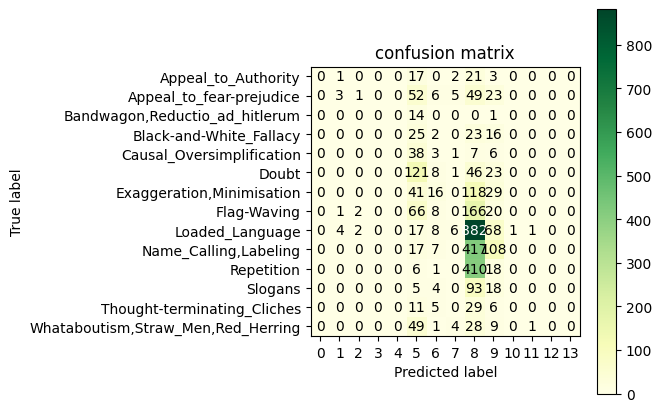

In [ ]:
trainer.fit(model, dm)

This command is used to save checkpoints needed for subtask 1.

It is commented to not overwrite the checkpoints of the best performing model already saved.

In [ ]:
trainer.save_checkpoint(PTC_checkpoints+"PTC_"+checkpoint_name+"_FL.ckpt")


In [ ]:

# Save the model
model_save_path = PTC_checkpoints + "PTC_" + checkpoint_name + "_FL.ckpt"

print(f"Model saved to: {model_save_path}") # Print the save path

Model saved to: /content/drive/MyDrive/DeepProject/Model/PTC/PTC_google_electra-base-discriminator_FL.ckpt


In [ ]:
# checkpoint_path ="/content/drive/MyDrive/DeepProject/Model/PTC/PTC_bert-base-cased_FL.ckpt"
# PTC_checkpoints = torch.load(checkpoint_path)

# Subtask 1
Given the textual content of a meme, identify which of the 20 techniques are used in it (multilabel classification problem)

The main paper from which we got inspired is: [MinD at SemEval-2021 Task 6](https://aclanthology.org/2021.semeval-1.150.pdf), which ranked first in the challenge.

The approach used from the MinD team consists in fine tuning different pre-trained transformers models and then ensemble them to obtain the final predictions by averaging the probabilities from the models.

The models we fine-tuned are the ones obtained from the previous section (PTC).

The official evaluation measure for this subtask is micro-F1.


In [ ]:
gc.collect()

127968

In [ ]:
Task1_checkpoints= folder_name + "Model/SubTask1/"

## Dataset

The train, dev and test datasets contain 688, 63 and 200 memes respectively.

The distribution of samples among the classes is highly unbalanced (similarly to PTC's dataset).

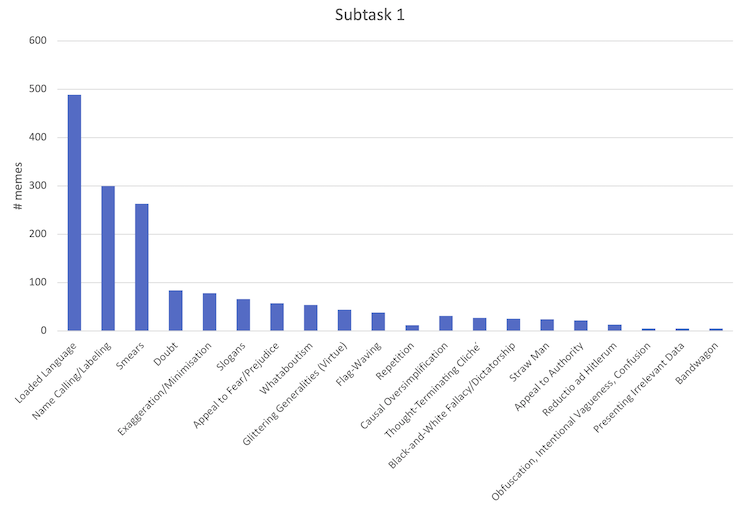

In [ ]:
dataset_folder=folder_name+"PTC_Dataset/"
train_st1 = "/content/drive/MyDrive/DeepProject/training_set_task1.txt"
dev_st1 = "/content/drive/MyDrive/DeepProject/dev_set_task1.txt"
test_st1 = "/content/drive/MyDrive/DeepProject/test_set_task1.txt"

In [ ]:
train_data1=pd.read_json(train_st1)
dev_data1=pd.read_json(dev_st1)
test_data1=pd.read_json(test_st1)

In [ ]:
train_data1

,id,labels,text
0,128,[Black-and-white Fallacy/Dictatorship],THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n
1,189,[],This is not an accident!
2,96,"[Loaded Language, Name calling/Labeling, Sloga...",SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...
3,154,"[Causal Oversimplification, Loaded Language, N...",PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...
4,15,[],WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n
...,...,...,...
683,501_batch_2,[Smears],"HOW TO KILL THE CORONOVIRUS...\nHey Hillary, I..."
684,508_batch_2,[],"LOOK, WHEN I'M IN THE WAFFLE HOUSE, I'M GOING ..."
685,509_batch_2,"[Loaded Language, Name calling/Labeling]",I support MLB\n\nIt's BLM you idiot
686,510_batch_2,[Loaded Language],"PELOSI ENDORSES BIDEN\n""He is a leader who is ..."


In [ ]:
print("Number of samples in the train dataset: {}, validation dataset: {} and test dataset: {}".format(len(train_data1.text.values), len(dev_data1.text.values), len(test_data1.text.values)))

Number of samples in the train dataset: 688, validation dataset: 63 and test dataset: 200


In [ ]:
techniques = [['Appeal to authority', 'Appeal to fear/prejudice', 'Bandwagon',
               'Black-and-white Fallacy/Dictatorship',
               'Causal Oversimplification', 'Doubt', 'Exaggeration/Minimisation',
               'Flag-waving', 'Glittering generalities (Virtue)',
               'Loaded Language',
               "Misrepresentation of Someone's Position (Straw Man)",
               'Name calling/Labeling',
               'Obfuscation, Intentional vagueness, Confusion',
               'Presenting Irrelevant Data (Red Herring)', 'Reductio ad hitlerum',
               'Repetition', 'Slogans', 'Smears', 'Thought-terminating cliché',
               'Whataboutism']]

In [ ]:
class Task1Dataset(Dataset):
    def __init__(self, input_id, attention, labels):
        self.attention = attention
        self.input_id = input_id
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        attention = self.attention[idx]
        label = self.labels[idx]
        input_id = self.input_id[idx]
        sample = {"attention_mask": attention,
                  "input_ids": input_id, "labels": label}
        return sample

##Loss Functions

To deal with this unbalanced dataset, we tried to use several loss functions that could handle such disparities.

A first approach consisted in a weighted version of Binary Cross Entropy which adds weights to positive samples in the loss function with the following formula (from [Volta at SemEval-2021 Task 6](https://arxiv.org/pdf/2106.00240.pdf)):

$l(x,y) = - \dfrac{1}{Nd}\sum_{n=1}^{N}\sum_{k=1}^{d}[p^k y_n^k \log(x_n^k) + (1 - y_n^k)\log(1-x_n^k)]$

where $p^k = \dfrac{1}{f^k}(|K| - f^k)$, $N$ is the batch size, $n$ is and index for the $n^{th}$ batch element, $d$ is the number of classes, $f$ stands for a vector of class absolute frequencies, $x$ is a vector from the last Sigmoid layer, y is a vector representing the labels and $|K|$ is the size of the train set.

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, y_train):
        super(WeightedBCELoss, self).__init__()
        self.y_train = y_train
        self.pos_weight = self.weighted_factors()

    def forward(self, logits, labels):
        loss = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight, reduction='mean')
        return loss(logits, labels)

    def weighted_factors(self):
        f = torch.sum(self.y_train, dim=0)
        N = len(self.y_train)
        K = torch.full(size=f.size(), fill_value=N)
        pos_weight = torch.div(torch.sub(K, f), f).to(device=device)
        return pos_weight

As second approach we use [Focal loss](https://arxiv.org/pdf/1708.02002.pdf) which focuses on improving predictions on hard misclassified examples.

This is achieved by adding the two hyper-parameters to the cross entropy loss, $\alpha$ and $γ$, where $α$ controls the weight of positive and negative samples and $γ$ scales the loss of hard and easy samples.

So, for the $i^{th}$ class:
$L_{class_i}=\begin{cases}
α(1-p)^γ\log(p),& \text{if y=1} \\
(1-α)p^γ\log(1-p),& \text{otherwise}
\end{cases}
$, where $y$ is the ground truth and $p$ is the model's prediction.

In our experiments we noticed worse results for values of $α$ different from 1, so we deleted this parameter and kept just the focusing parameter $γ$.

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        #self.alpha = alpha
        self.gamma = gamma
        self.BCE = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.BCE(inputs,targets)
        pt = torch.exp(-BCE_loss)
        #F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        F_loss =  (1-pt)**self.gamma * BCE_loss

        return torch.mean(F_loss)

## Lightning DataModule

In [ ]:
class Task1DataModule(LightningDataModule):
    def __init__(
        self,
        train_data,
        test_data,
        le,
        val_data,
        techniques,
        num_classes: int = 20,
        model_name: str = "google/electra-base-discriminator",
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)
        self.mlb = MultiLabelBinarizer()
        self.le=le
    def setup(self, stage: str = None):
        self.X_train = self.train_data.text.values
        self.mlb.fit(self.techniques)
        y_train = self.mlb.transform(self.train_data.labels.values)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_val = self.val_data.text.values
        y_val = self.mlb.transform(self.val_data.labels.values)

        self.max_length = self.maxLen()

        self.X_train_enc, self.X_train_attention = self.preprocessing(
            self.X_train)
        self.X_val_enc, self.X_val_attention = self.preprocessing(
            self.X_val)
        self.X_test_enc, self.X_test_attention = self.preprocessing(
            self.X_test)

        self.y_train = torch.tensor(y_train)
        self.y_val = torch.tensor(y_val)
        self.y_test = torch.tensor(y_test)

    def prepare_data(self):
        return

    def train_dataloader(self):
        data = Task1Dataset(
            self.X_train_enc, self.X_train_attention, self.y_train)
        train_dataloader = DataLoader(data, batch_size=self.batch_size)
        return train_dataloader

    def val_dataloader(self):
        data = Task1Dataset(self.X_val_enc, self.X_val_attention, self.y_val)
        val_dataloader = DataLoader(data, batch_size=self.batch_size)
        return val_dataloader

    def test_dataloader(self):
        data = Task1Dataset(
            self.X_test_enc, self.X_test_attention, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        input_ids = []
        attention_masks = []

        for sent in data:
            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = self.tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        return input_ids, attention_masks

    def maxLen(self):
        tmp = np.concatenate([self.X_train, self.X_test])
        X_all = np.concatenate([tmp, self.X_val])

        encoded_X = [
            self.tokenizer.encode(
                sent,
                add_special_tokens=True
            ) for sent in X_all
        ]

        max_len = max([len(sent) for sent in encoded_X])
        return max_len

In [ ]:
dm = Task1DataModule(train_data1, test_data1, val_data=dev_data1,le=2.00e-05, techniques=techniques,
                      model_name=pretrained_transformer_name, batch_size=8)
dm.setup()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Subtask 1 Model

Class that implements the callback that prints the metrics that are used to evaluate a model.

In [ ]:
class Task1EvaluateCallback(Callback):
    def on_fit_end(self, trainer, model):
        print("Fit end: Evaluation....")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def on_test_end(self, trainer, model):
        print("Test metrics:")

        all_predictions = model.predictions.int()
        all_labels = model.labels.int()

        classes = model.mlb.classes_

        self.print_evaluation(all_predictions, all_labels,
                              classes, model.num_classes)

        model.predictions = torch.Tensor()
        model.labels = torch.Tensor()

        return

    def print_evaluation(self, all_predictions, all_labels, classes, num_classes):
        all_predictions = all_predictions.detach().cpu()
        all_labels = all_labels.detach().cpu()

        confMatrix = torchmetrics.ConfusionMatrix(task="multilabel", num_labels=num_classes)
        conf_mat = confMatrix(all_predictions, all_labels)
        plot_confusion_multi(conf_mat, classes)

        print("F1-micro: {}".format(f1_score(all_labels,
              all_predictions, average="micro", zero_division=1)))
        print("F1-macro: {}".format(f1_score(all_labels,
              all_predictions, average="macro", zero_division=1)))

        print(classification_report(all_labels, all_predictions, labels=[
              i for i in range(num_classes)], target_names=classes, zero_division=1))

        return

In this section we load the transformer model previously trained on PTC dataset by passing its name as input to the Task1Model class and then we add a classifier on top of it that takes the [CLS] token from the transformer as input. This classifier is composed by two layers with Dropout and as activation function ReLU.

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
class Task1Model(LightningModule):
    def __init__(
        self,
        mlb,
        y_train,
        le,
        num_classes: int = 20,
        model_name_or_path: str = "google/electra-base-discriminator",
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
        warmup_steps: int = 500,
        weight_decay: float = 0.1,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()  # Correct initialization

        self.mlb = mlb
        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.save_hyperparameters()
        self.le = le
        self.threshold = 0.5
        self.outputs = []
        self.num_classes = num_classes

        #self.loss = torch.nn.BCEWithLogitsLoss()
        self.loss = FocalLoss()
        #self.loss = WeightedBCELoss(y_train)
        self.acc = torchmetrics.Accuracy(task='multilabel', num_labels=num_classes)

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

        D_in, H, D_out = 768, 96, self.num_classes
        loaded_model = PTCTransformer.load_from_checkpoint('/content/drive/MyDrive/DeepProject/Model/PTC/PTC_google_electra-base-discriminator_FL.ckpt')
        self.transformer = loaded_model
        self.transformer.classifier = Identity()

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(H, D_out)
        )

    def forward(self, **inputs):
        cls_output = self.transformer(**inputs)
        logits = self.classifier(cls_output)
        return logits

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        logits = self(**batch)
        loss = self.loss(logits, labels.to(torch.float32))
        self.log('train_loss', loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('train_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)

        return {"loss": loss, "accuracy": acc}

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        val_loss = self.loss(logits, labels.to(torch.float32))
        self.log('val_loss', val_loss, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('val_acc', acc, prog_bar=True,
                 on_epoch=True, on_step=True,  logger=True)
        self.outputs.append({"loss": val_loss, "accuracy": acc, # Append outputs to self.outputs
                "predictions": predictions, "labels": labels})
        return {"loss": val_loss, "accuracy": acc,
                "predictions": predictions, "labels": labels}

    def validation_step_end(self, outputs):
        self.outputs.append(outputs)  # Append the outputs to the list
        return outputs

    def on_validation_epoch_end(self):
        if self.current_epoch == self.trainer.max_epochs - 1:
            # Debug print to check if outputs list is empty
            print(f"Outputs length: {len(self.outputs)}")

            if len(self.outputs) == 0:
                print("Warning: No outputs collected during validation.")
                return

            labels = [x["labels"] for x in self.outputs]
            self.labels = torch.cat(labels, dim=0)

            predictions = [x["predictions"] for x in self.outputs]
            self.predictions = torch.cat(predictions, dim=0)

            self.outputs = []  # Clear the outputs list

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        labels = batch["labels"]
        test_loss = self.loss(logits, labels.to(torch.float32))
        self.log('test_loss', test_loss, prog_bar=True, logger=True)
        predictions = (torch.sigmoid(logits) > self.threshold).int()
        acc = self.acc(predictions, labels)
        self.log('test_acc', acc, prog_bar=True, logger=True)

        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)
        return {"loss": test_loss, "accuracy": acc}

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self(**batch)
        predictions = (torch.sigmoid(logits) >
                       self.threshold).int().detach().cpu().numpy()
        return self.mlb.inverse_transform(predictions)

    def configure_optimizers(self):
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.weight_decay,
            },
            {
                "params": [p for n, p in self.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters,
                          lr=self.learning_rate, eps=self.adam_epsilon)

        return [optimizer]

## Train and Validation

In [ ]:
model = Task1Model(
    mlb=dm.mlb,      # Optional
    y_train=dm.y_train,  # Optional
    le=dm.le,  # Pass le appropriately
    num_classes=20,  # Specify the number of classes
    model_name_or_path=checkpoint_name  # Checkpoint path
)

In [ ]:
log_dir = logs_dir+"SubTask1/"

In [ ]:
logger = TensorBoardLogger(
    log_dir, name="SubTask1_net_"+checkpoint_name, version="TEST", log_graph=True)

In [ ]:
import pytorch_lightning as pl

In [ ]:
my_trainer=pl.Trainer(max_epochs=10,accelerator="gpu",devices=AVAIL_GPUS,logger=logger,callbacks=[Task1EvaluateCallback()])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | loss        | FocalLoss          | 0      | train
1 | acc         | MultilabelAccuracy | 0      | train
2 | transformer | PTCTransformer     | 108 M  | train
3 | classifier  | Sequential         | 75.8 K | train
-----------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.870   Total estimated model params size (MB)
14        Modules in train mode
225     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Outputs length: 82


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Fit end: Evaluation....
F1-micro: 0.42824392480513523
F1-macro: 0.09075641685434939
                                                     precision    recall  f1-score   support

                                Appeal to authority       0.00      0.00      0.00        20
                           Appeal to fear/prejudice       0.08      0.02      0.04        41
                                          Bandwagon       0.00      0.00      0.00        20
               Black-and-white Fallacy/Dictatorship       0.00      1.00      0.00         0
                          Causal Oversimplification       0.06      0.09      0.07        11
                                              Doubt       0.12      0.02      0.04        82
                          Exaggeration/Minimisation       1.00      0.00      0.00        73
                                        Flag-waving       1.00      0.00      0.00        51
                   Glittering generalities (Virtue)       0.00      0.00      

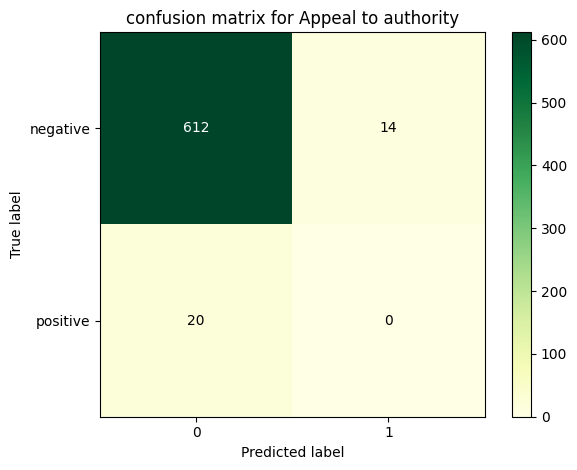

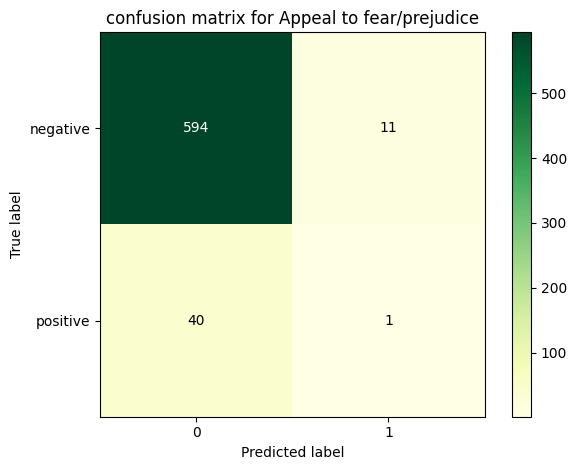

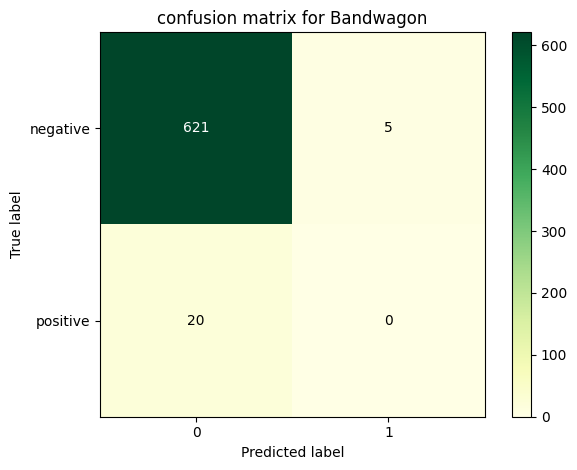

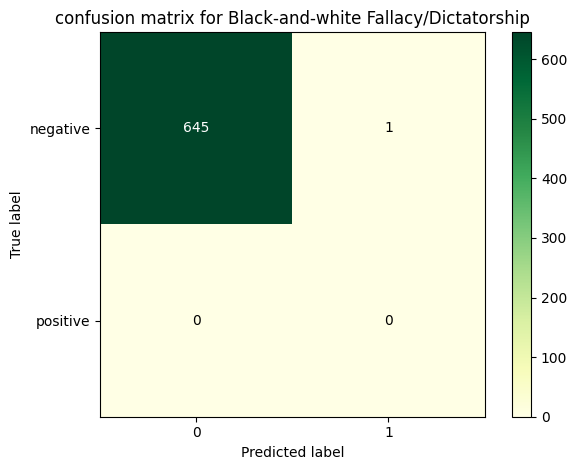

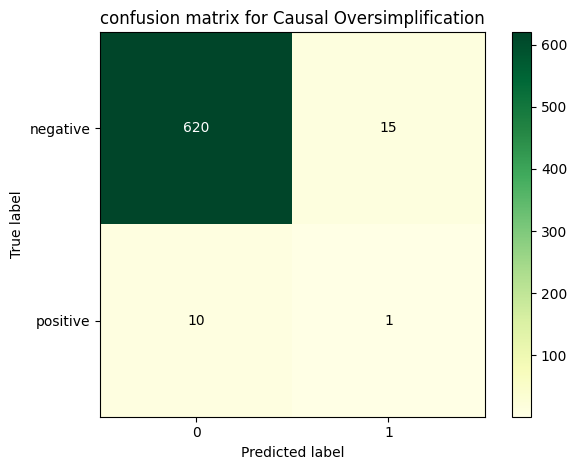

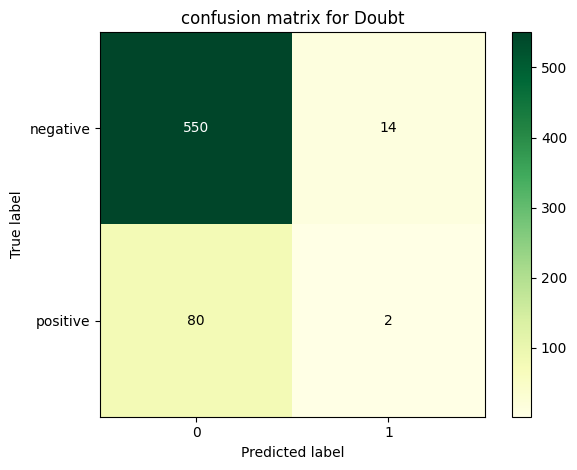

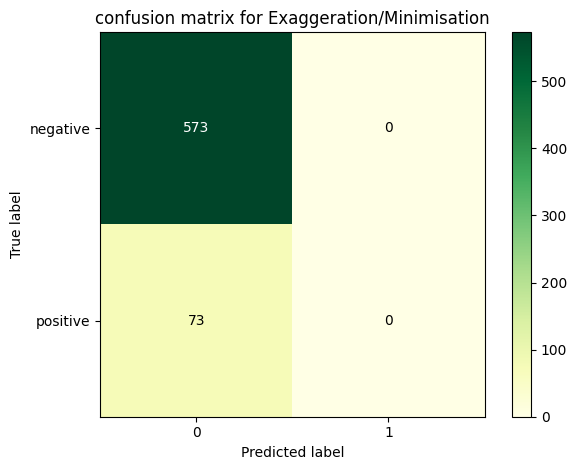

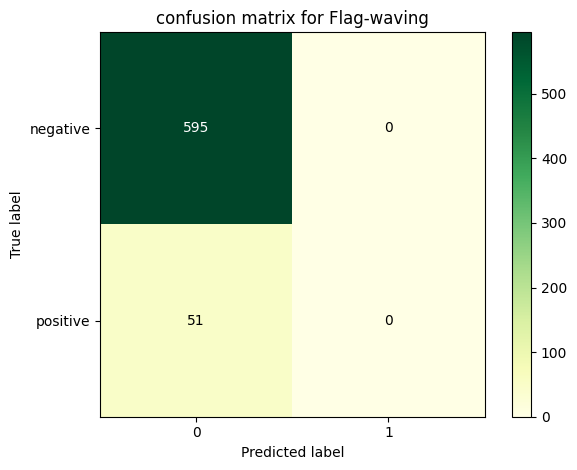

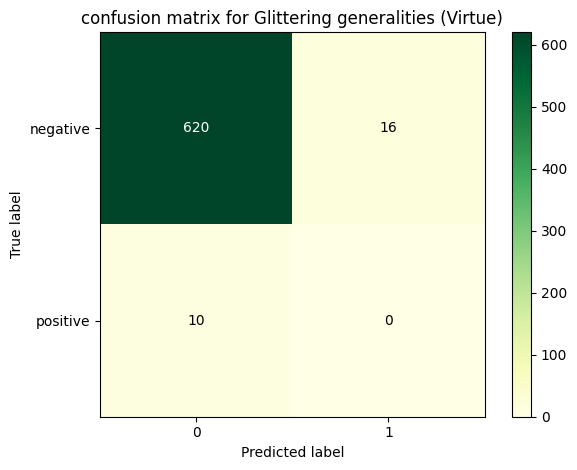

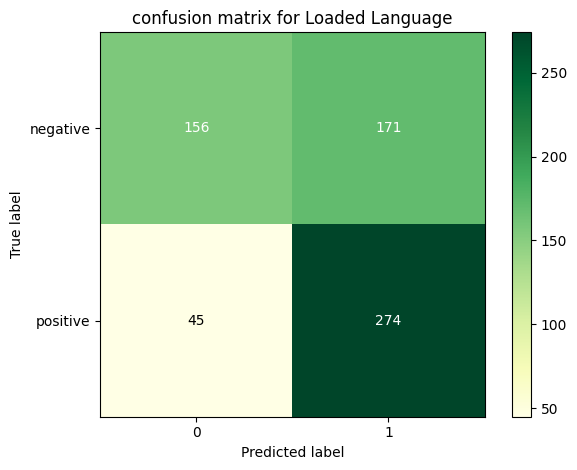

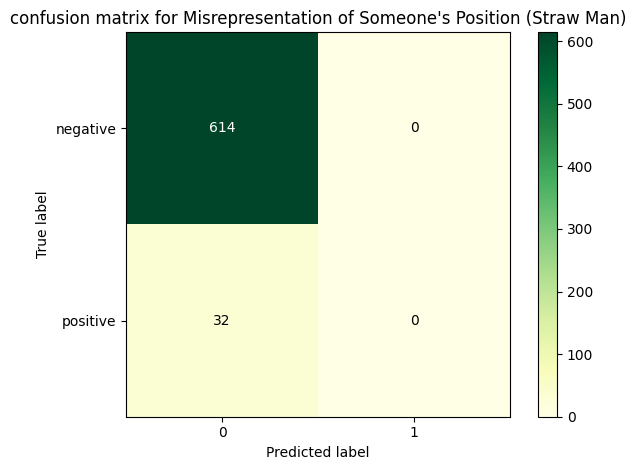

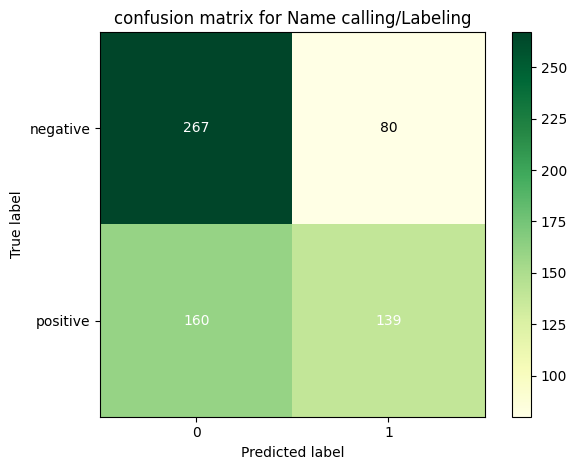

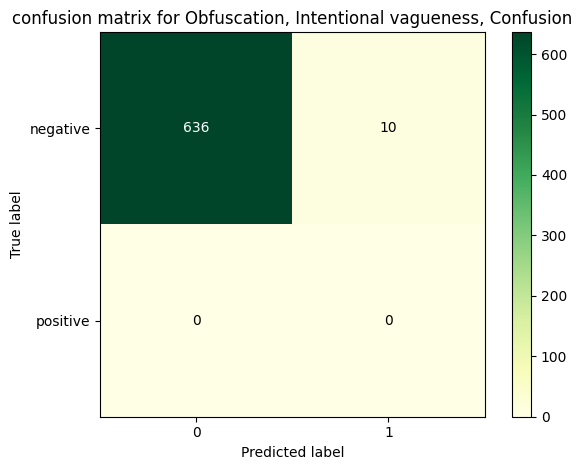

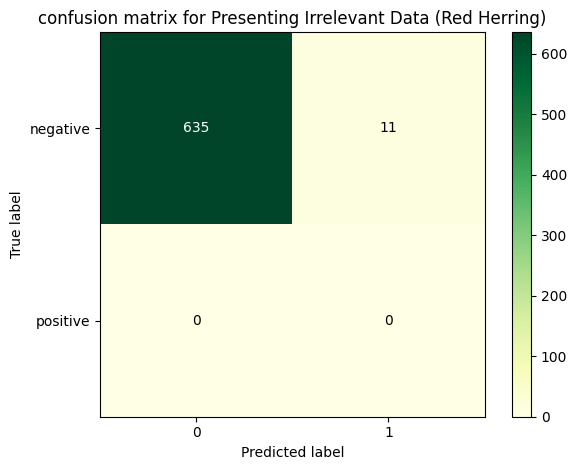

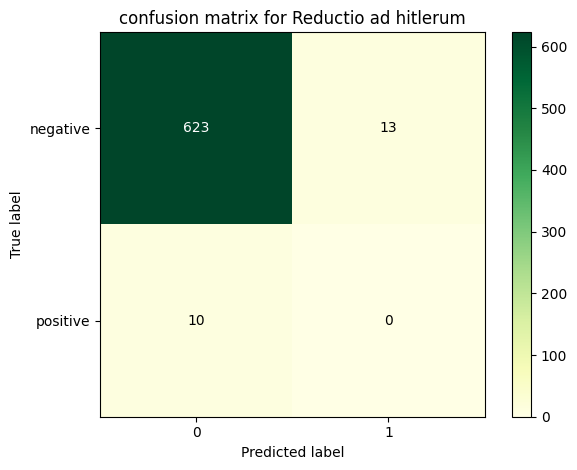

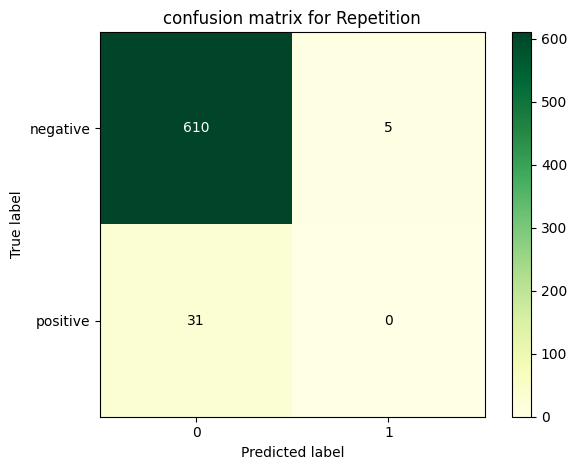

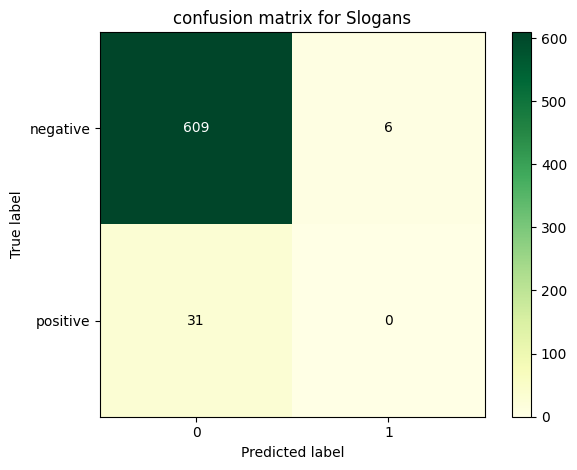

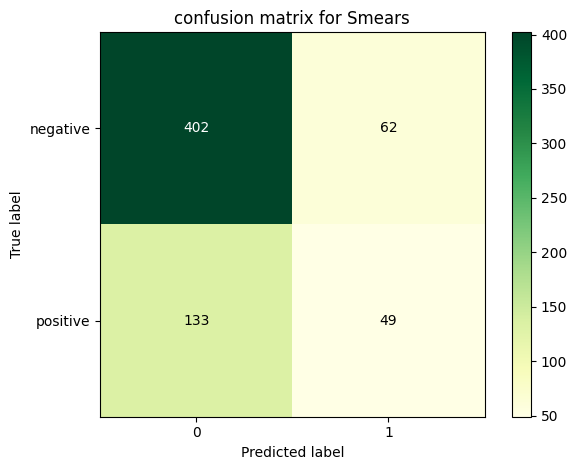

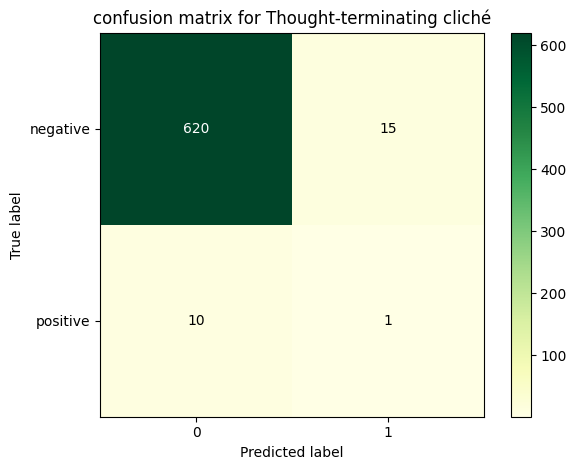

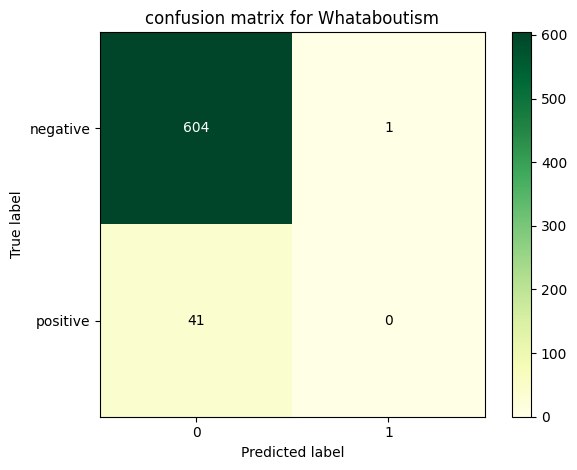

In [ ]:
my_trainer.fit(model, dm)

This command is used to save checkpoints needed for the ensemble.

It is commented to not overwrite the checkpoints of the best performing model already saved.

In [ ]:
my_trainer.save_checkpoint(Task1_checkpoints+"SubTask1_"+checkpoint_name+"_FL.ckpt")

## Testing

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Testing: |          | 0/? [00:00<?, ?it/s]

Test metrics:
F1-micro: 0.4612850082372323
F1-macro: 0.07867239198049052
                                                     precision    recall  f1-score   support

                                Appeal to authority       1.00      0.00      0.00         7
                           Appeal to fear/prejudice       1.00      0.00      0.00        10
                                          Bandwagon       1.00      0.00      0.00         1
               Black-and-white Fallacy/Dictatorship       1.00      0.00      0.00         7
                          Causal Oversimplification       1.00      0.00      0.00         3
                                              Doubt       1.00      0.00      0.00        28
                          Exaggeration/Minimisation       1.00      0.00      0.00        19
                                        Flag-waving       1.00      0.00      0.00         6
                   Glittering generalities (Virtue)       1.00      0.00      0.00       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9182499647140503     │
│         test_loss         │    0.07145556807518005    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07145556807518005, 'test_acc': 0.9182499647140503}]

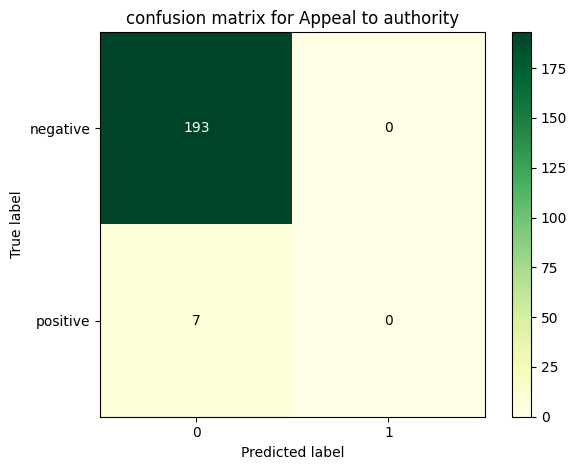

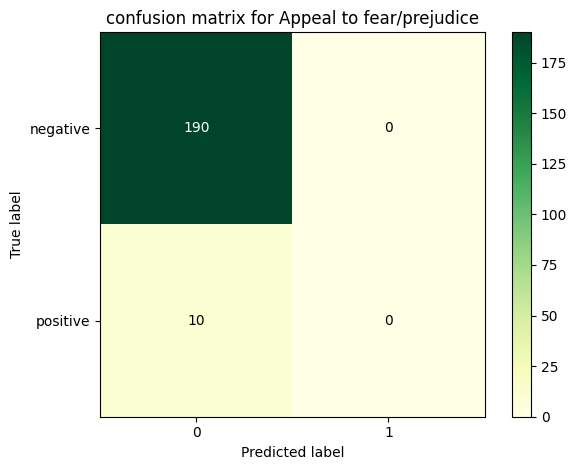

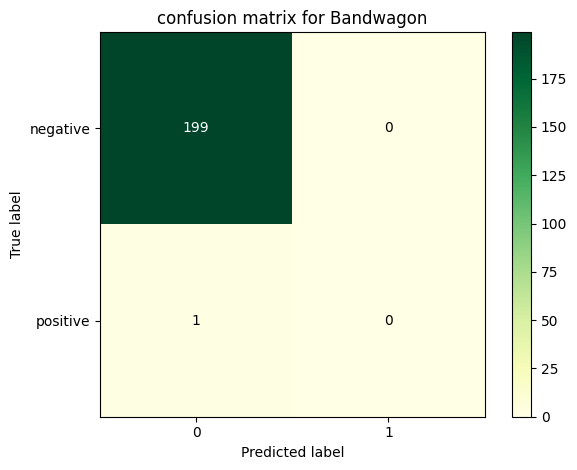

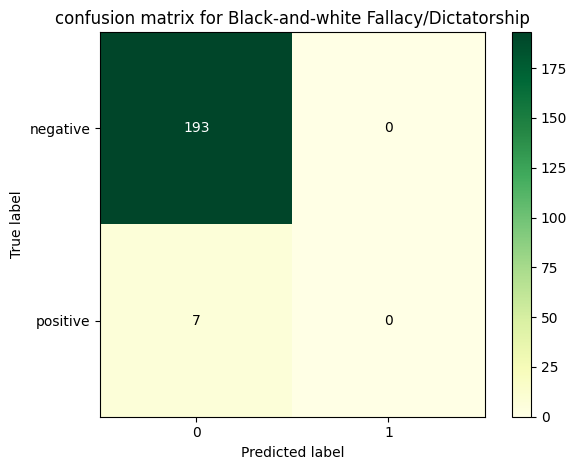

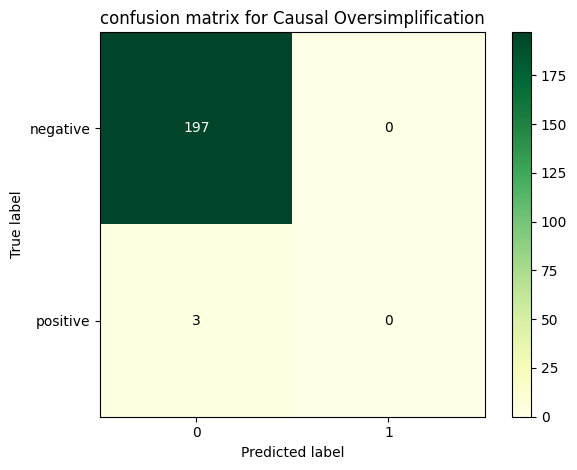

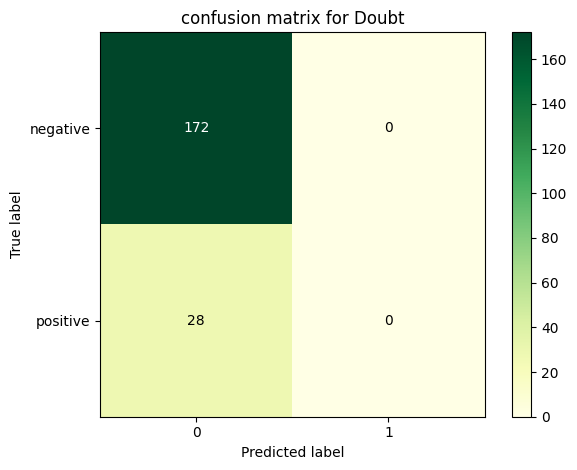

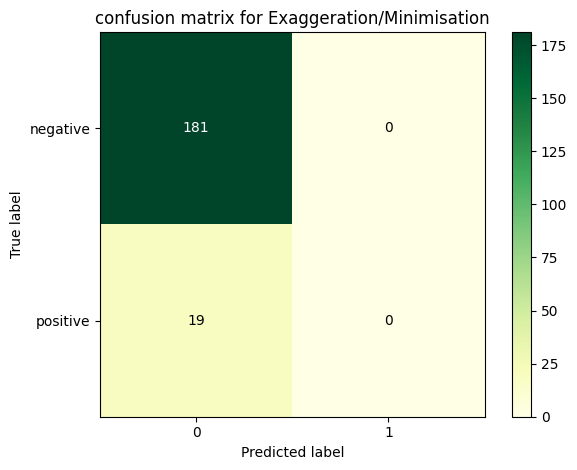

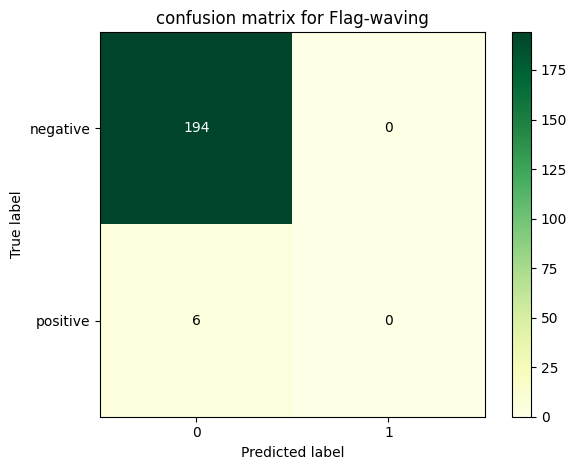

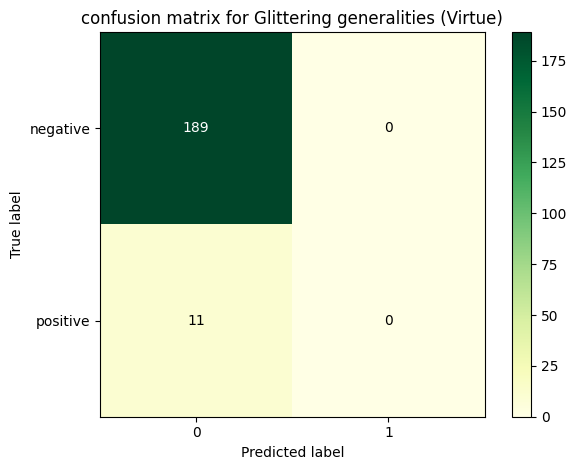

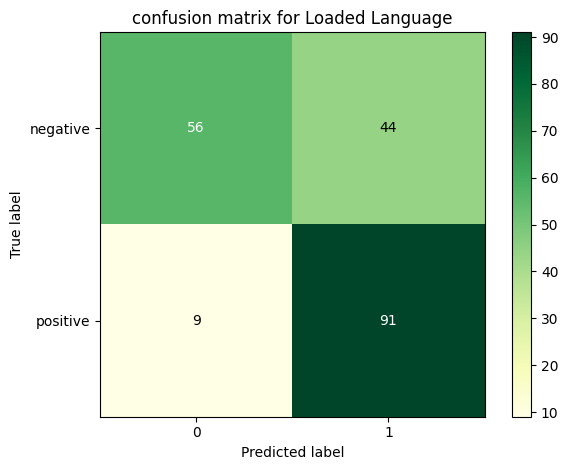

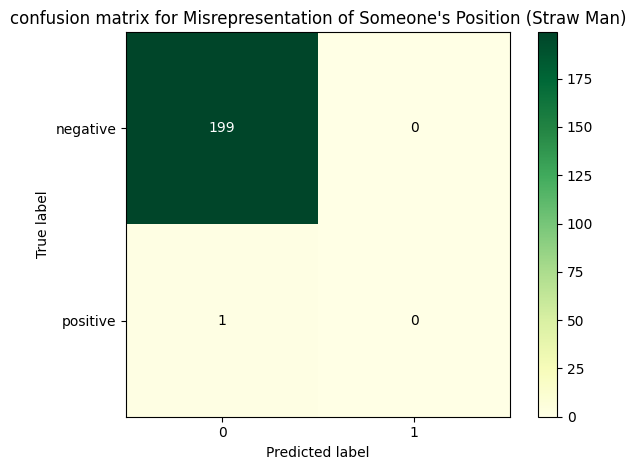

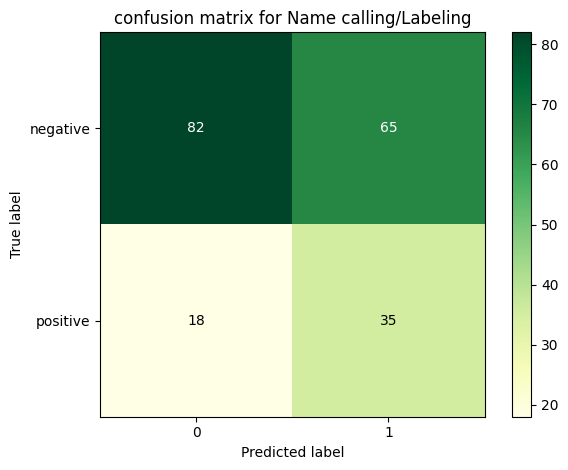

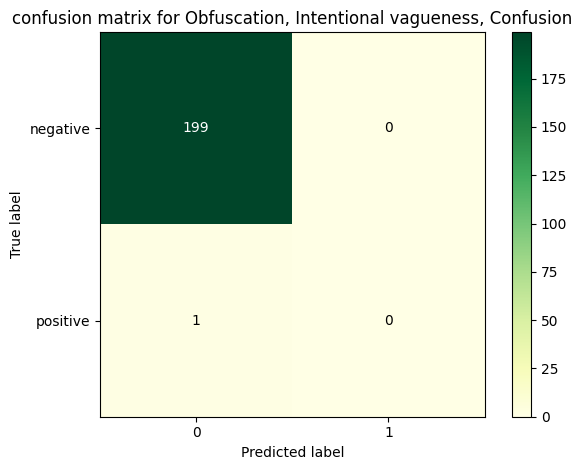

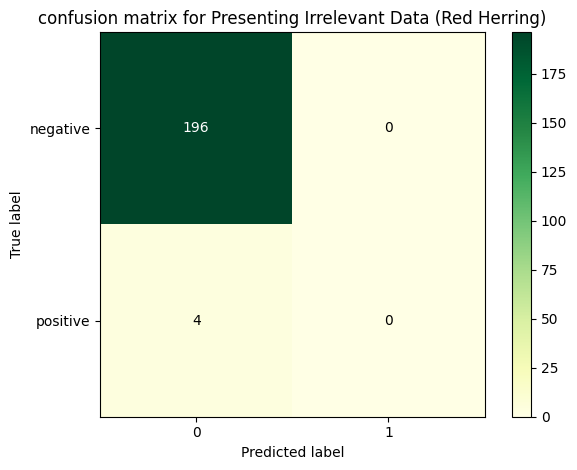

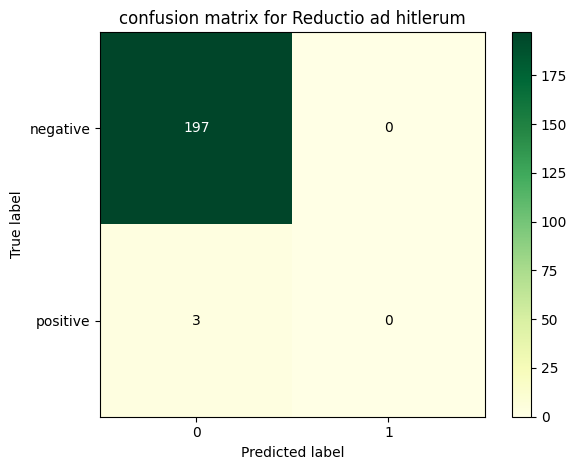

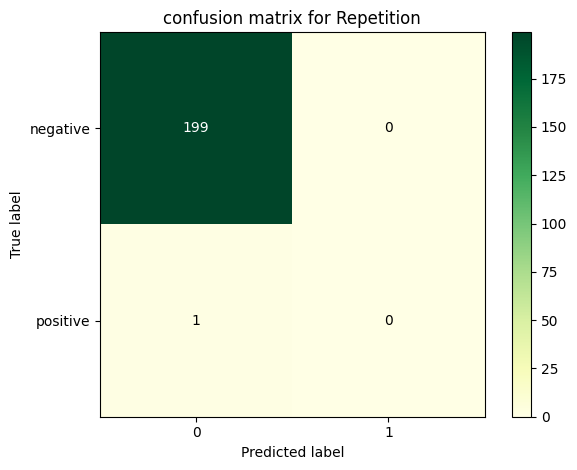

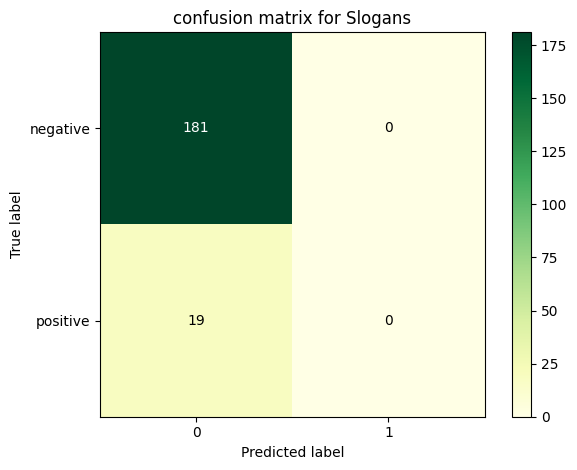

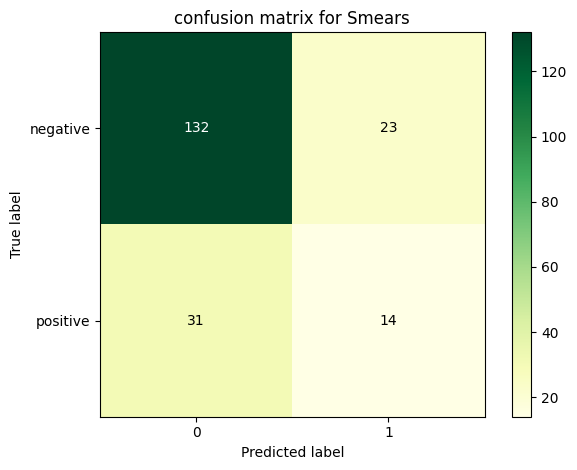

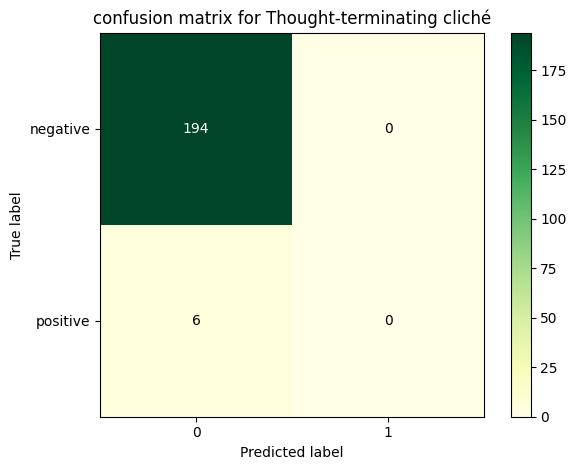

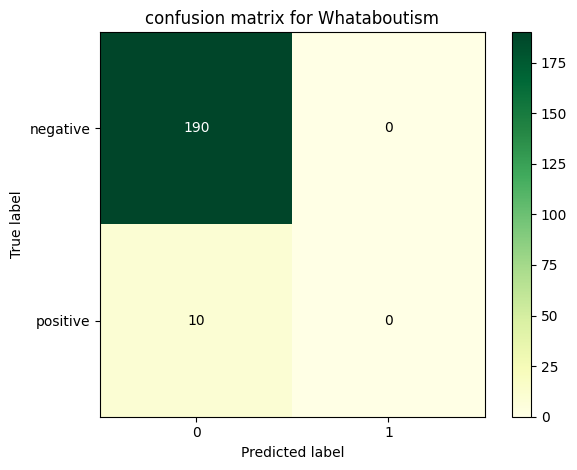

In [ ]:
my_trainer.test(model, dm)

## Example prediction


Print some predictions made from the model on few samples and their true labels.

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = my_trainer.predict(model, predict_dataloader)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
for i in range(5):
    text = test_data1.text.values[i].replace(
        '\\', "").replace('\n', ' ').strip()
    labels = test_data1.labels.values[i]
    preds = predictions[0][i]
    print("Text: '{}'".format(text))
    print("Predicted techniques: {}".format(preds))
    print("Correct techniques: {}".format(labels))
    print("-"*180)

Text: 'The Democrats New America'
Predicted techniques: ()
Correct techniques: ['Name calling/Labeling', 'Slogans']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text: 'WE ARE AT WAR!  There is a complex assault on our presidential election with all the multifaceted tentacles of a terrorist organization and operation  2020 TERRORISM'
Predicted techniques: ('Loaded Language', 'Name calling/Labeling')
Correct techniques: ['Appeal to fear/prejudice', 'Loaded Language', 'Name calling/Labeling']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text: 'KILLED HIMSELF IN PRISON  WON AN HONEST ELECTION'
Predicted techniques: ('Loaded Language',)
Correct techniques: ['Loaded Language', 'Name calling/Labeling']
-----------------------

The best results are obtained with the following configuration of the main parameters:

| Parameters (TASK 1) 	|          	|
|:-------------------:	|:--------:	|
|       Dropout       	|   0.10   	|
|      Batch Size     	|     8    	|
|    Learning Rate    	| 2,00E-05 	|
|      Optimizer      	|   AdamW  	|
|    Warm Up Steps    	|    500   	|
|     Weight Decay    	|    0.1   	|
|     Adam Epsilon    	| 1,00E-08 	|
|        Epochs       	|    10    	|

In the following tables are reported some of the tests done for this subtask.

Models fine-tuned on PTC are slightly better than the ones that are taken directly from HuggingFace library.


|          Model         	| Epochs 	|       Loss      	| F1 micro 	| F1 macro 	| F1 micro test 	| F1 macro test 	|
|:----------------------:	|:------:	|:---------------:	|:--------:	|:--------:	|:-------------:	|:-------------:	|
| **Bert base (no PTC)** 	|   10   	|    Focal loss   	|   0.47   	|   0.24   	|      0.38     	|      0.06     	|
| **Bert base (no PTC)** 	|   20   	| WeightedBCELoss 	|   0.46   	|   0.33   	|      0.37     	|      0.13     	|
|                        	|        	|                 	|          	|          	|               	|               	|
|   **Bert base (PTC)**  	|   10   	|    Focal loss   	|   0.53   	|   0.31   	|      0.47     	|      0.10     	|
|   **Bert base (PTC)**  	|   20   	| WeightedBCELoss 	|   0.53   	|   0.37   	|      0.44     	|      0.20     	|

In general models with Focal Loss got better results compared to plain BCE Loss and Weighted BCE Loss.

AdamW and Adam got very similar results.

The model that has the best F1-score is DeBerta base, but this was predictable since it is the biggest model.

|    Model (TASK 1)   	|       Loss       	|    DEV-SET   	|              	|   TEST-SET   	|              	|        Scheduler       	|
|:-------------------:	|:----------------:	|:------------:	|:------------:	|:------------:	|:------------:	|:----------------------:	|
|                     	|                  	| **F1-micro** 	| **F1-macro** 	| **F1-micro** 	| **F1-macro** 	|                        	|
|       **BERT**      	|        BCE       	|     0.53     	|     0.25     	|     0.47     	|     0.08     	|            -           	|
|                     	|                  	|     0.54     	|     0.25     	|     0.47     	|     0.09     	| Constant  with warmups 	|
|       **BERT**      	|  WeightedBCELoss 	|     0.45     	|     0.31     	|     0.36     	|     0.18     	|            -           	|
|                     	|                  	|     0.38     	|     0.24     	|     0.33     	|     0.17     	| Constant  with warmups 	|
|       **BERT**      	|     FocalLoss    	|     0.53     	|     0.31     	|     0.47     	|     0.10     	|            -           	|
|                     	|                  	|     0.51     	|     0.24     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|      **ALBERT**     	|        BCE       	|     0.57     	|     0.25     	|     0.49     	|     0.08     	|            -           	|
|                     	|                  	|     0.53     	|     0.24     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|      **ALBERT**     	|  WeightedBCELoss 	|     0.48     	|     0.30     	|     0.43     	|     0.15     	|            -           	|
|                     	|                  	|     0.44     	|     0.28     	|     0.40     	|     0.19     	| Constant  with warmups 	|
|      **ALBERT**     	|     FocalLoss    	|     0.56     	|     0.27     	|     0.50     	|     0.10     	|            -           	|
|                     	|                  	|     0.53     	|     0.28     	|     0.50     	|     0.11     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|     **RoBERTa**     	|        BCE       	|     0.55     	|     0.25     	|     0.48     	|     0.08     	|            -           	|
|                     	|                  	|     0.52     	|     0.24     	|     0.47     	|     0.08     	| Constant  with warmups 	|
|     **RoBERTa**     	|  WeightedBCELoss 	|     0.50     	|     0.33     	|     0.36     	|     0.19     	|            -           	|
|                     	|                  	|     0.42     	|     0.26     	|     0.36     	|     0.20     	| Constant  with warmups 	|
|     **RoBERTa**     	|     FocalLoss    	|     0.55     	|     0.30     	|     0.49     	|     0.12     	|            -           	|
|                     	|                  	|     0.49     	|     0.27     	|     0.44     	|     0.09     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|     **DeBERTa**     	|        BCE       	|     0.51     	|     0.24     	|     0.50     	|     0.09     	|            -           	|
|                     	|                  	|     0.53     	|     0.23     	|     0.46     	|     0.08     	| Constant  with warmups 	|
|     **DeBERTa**     	| WeightedBCELoss  	|     0.56     	|     0.50     	|     0.41     	|     0.24     	|            -           	|
|                     	|                  	|     0.47     	|     0.33     	|     0.38     	|     0.22     	| Constant  with warmups 	|
|     **DeBERTa**     	|    FocalLoss     	|     0.57     	|     0.33     	|     0.52     	|     0.13     	|            -           	|
|                     	|                  	|     0.60     	|     0.32     	|     0.49     	|     0.13     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
|      **XLNet**      	|        BCE       	|     0.50     	|     0.30     	|     0.49     	|     0.13     	|            -           	|
|                     	|                  	|     0.50     	|     0.26     	|     0.48     	|     0.10     	| Constant  with warmups 	|
|      **XLNet**      	|  WeightedBCELoss 	|     0.55     	|     0.33     	|     0.43     	|     0.21     	|            -           	|
|                     	|                  	|     0.44     	|     0.33     	|     0.38     	|     0.21     	| Constant  with warmups 	|
|      **XLNet**      	|     FocalLoss    	|     0.54     	|     0.35     	|     0.49     	|     0.13     	|            -           	|
|                     	|                  	|     0.58     	|     0.33     	|     0.44     	|     0.10     	| Constant  with warmups 	|
|                     	|                  	|              	|              	|              	|              	|                        	|
| **Random Baseline** 	|                  	|     0.06     	|     0.04     	|     0.05     	|     0.03     	|                        	|

## Ensemble

In [ ]:
model_names = ["bert-base-cased", "roberta-base",
               "xlnet-base-cased", "microsoft/deberta-base", "albert-base-v2"]

### Dataset and DataModule

In [ ]:
class EnsemblerDataset(Dataset):
    def __init__(self, data_dict, labels):
        self.data_dict = data_dict
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample_dict = {}
        for model in self.data_dict.keys():
            sample_dict[model] = {}
            attention = self.data_dict[model]["attention_mask"][idx]
            input_id = self.data_dict[model]["input_ids"][idx]
            sample_dict[model] = {
                "attention_mask": attention, "input_ids": input_id}

        sample_dict["labels"] = self.labels[idx]
        return sample_dict

In [ ]:
class EnsemblerDataModule(LightningDataModule):
    def __init__(
        self,
        test_data,
        techniques,
        models_list: list,
        num_classes: int = 20,
        batch_size: int = 8,
        **kwargs,
    ):
        super().__init__()

        self.test_data = test_data
        self.techniques = techniques
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.models = models_list
        self.mlb = MultiLabelBinarizer()
        self.max_length = 512

    def setup(self, stage: str = None):
        self.mlb.fit(self.techniques)

        self.X_test = self.test_data.text.values
        y_test = self.mlb.transform(self.test_data.labels.values)

        self.X_dict = self.preprocessing(self.X_test)

        self.y_test = torch.tensor(y_test)

    def prepare_data(self):
        return

    def test_dataloader(self):
        data = EnsemblerDataset(self.X_dict, self.y_test)
        test_dataloader = DataLoader(data, batch_size=self.batch_size)
        return test_dataloader

    def preprocessing(self, data):
        data_dict = {}
        for model_name in self.models:
            data_dict[model_name] = {}
            input_ids, attention_masks = self.preprocessing_for_model(
                data, model_name)
            data_dict[model_name]["input_ids"] = input_ids
            data_dict[model_name]["attention_mask"] = attention_masks

        return data_dict

    def preprocessing_for_model(self, data, model_name):
        tokenizer = AutoTokenizer.from_pretrained(
            model_name, do_lower_case=False)

        input_ids = []
        attention_masks = []

        for sent in data:
            preprocessed_sent = sent.replace(
                '\\', "").replace('\n', ' ').strip()
            encoded_sent = tokenizer.encode_plus(
                text=preprocessed_sent,
                add_special_tokens=True,
                max_length=self.max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True
            )

            input_ids.append(encoded_sent.get('input_ids'))
            attention_masks.append(encoded_sent.get('attention_mask'))

        input_ids = torch.tensor(input_ids)
        attention_masks = torch.tensor(attention_masks)
        return input_ids, attention_masks

In [ ]:
dm = EnsemblerDataModule(
    test_data1, techniques=techniques, models_list=model_names, batch_size=8)
dm.setup()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

### Ensembler with Mean

In [ ]:
class Ensembler(LightningModule):
    def __init__(self,
                 mlb,
                 model_names,
                 num_classes: int = 20,
                 threshold=0.5
                 ):
        super().__init__()
        self.model_names = model_names
        self.mlb = mlb
        self.num_classes = num_classes
        self.n_models = len(self.model_names)
        self.threshold = threshold
        print("Number of models in the ensemble: {}".format(self.n_models))
        self.models = self.load_models()

        self.register_buffer("labels", torch.Tensor())
        self.register_buffer("predictions", torch.Tensor())

    def forward(self, batch):
        preds = []
        for model_name in self.model_names:
            model = self.models[model_name]
            model.freeze()
            b = batch[model_name]

            x = model(**b)
            preds.append(x)
        preds = torch.stack(preds)
        logits = torch.mean(preds, axis=0)
        pred = (torch.sigmoid(logits) > self.threshold).int()
        return pred

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def test_step(self, batch, batch_idx, dataloader_idx=0):
        predictions = self(batch)
        labels = batch["labels"]
        self.labels = torch.cat((self.labels, labels), 0)
        self.predictions = torch.cat((self.predictions, predictions), 0)
        return

    def load_models(self):
        models = {}
        for model_name in model_names:
            checkpoint_name = model_name.replace("/", "_")
            ckpt_path = Task1_checkpoints+"SubTask1_"+checkpoint_name+"_FL.ckpt"
            loaded_model = Task1Model.load_from_checkpoint(
                checkpoint_path=ckpt_path)
            models[model_name] = loaded_model.to(device)
        return models

In [ ]:
ensemble = Ensembler(dm.mlb, model_names=model_names)

Number of models in the ensemble: 5


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DeepProject/Model/SubTask1/SubTask1_bert-base-cased_FL.ckpt'

In [ ]:
trainer = Trainer(max_epochs=1, gpus=AVAIL_GPUS, callbacks=[
                  Task1EvaluateCallback()])

In [ ]:
trainer.test(ensemble, dm)

In [ ]:
predict_dataloader = dm.test_dataloader()
predictions = trainer.predict(ensemble, predict_dataloader)

In [ ]:
for i in range(5):
    text = test_data1.text.values[i].replace(
        '\\', "").replace('\n', ' ').strip()
    labels = test_data1.labels.values[i]
    predicted_classes = dm.mlb.inverse_transform(predictions[0])
    print("Text: '{}'".format(text))
    print("Predicted techniques: {}".format(predicted_classes[i]))
    print("Correct techniques: {}".format(labels))
    print("-"*180)